<a href="https://colab.research.google.com/github/torayeff/RoboCupHumanoid/blob/master/Sweaty1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q torch==1.0.0 torchvision

In [ ]:
!pip install pillow==4.1.1
%reload_ext autoreload
%autoreload
device

## Clone repository, organize data into folder

In [ ]:
!git clone https://github.com/torayeff/RoboCupHumanoid.git
!mv RoboCupHumanoid/* .
!rm RoboCupHumanoid/ -rf
!mkdir data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp drive/'My Drive'/labivision/data/train.zip data/
!unzip -q data/train.zip -d data/
!rm data/train.zip

In [1]:
from conv_gru import ConvGruCellPreConv
import torch
import torch.nn as nn
import utils as utils
from sweaty_net_2_outputs import SweatyNet1
import time
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import peak
import matplotlib.cm as cm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Testing ConvLstm

In [8]:
#modelPath = 'pretrained_models/joan/epoch_100_sweaty.model'
#gru = 'pretrained_models/joan/epoch_100_gru.model'
modelPath = ''
gru=''

conv_gru = ConvGruCellPreConv(89, 1, device)
conv_gru.to(device)

model = SweatyNet1()
model.to(device)

if modelPath != '':
    print("Loading Sweaty")
    model.load_state_dict(torch.load(modelPath, map_location='cpu'))
    conv_gru.load_state_dict(torch.load(gru, map_location='cpu'))
    
print(model)

Model initialized
SweatyNet1(
  (conv_block1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv_block2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (conv_block3): Sequential(
    (0): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [4]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

trainset = utils.SoccerBallDataset("data/train/data.csv", "data/train", downsample=4)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=2, shuffle=True, num_workers=2)

Teacher signals are multiplied by  1000
Computing teacher signals...
Elapsed: 107.884945 sec.


In [12]:
utils.evaluate_model(model, trainset)

{'tps': 247, 'fps': 71, 'tns': 0, 'fns': 35}

In [27]:
t = utils.get_abs_threshold(trainset, 0.7)

torch.Size([1, 120, 160])


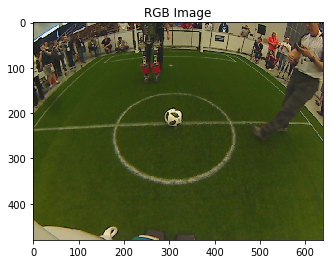

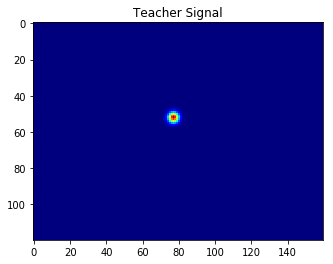

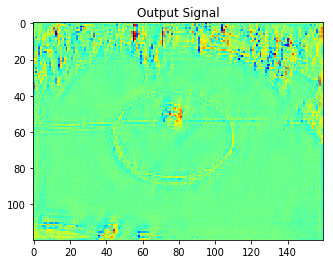

In [10]:
idx = 89
image = trainset[idx]['image']
signal = np.array(trainset[idx]['signal'].squeeze())

output, cat5 = model(image.unsqueeze(0).float().to(device))
input_for_gru = torch.cat([output, cat5], 1)

output = conv_gru(input_for_gru)

print(output.size())
output_signal = np.array(output.cpu().squeeze().detach())

#peak = utils.detect_max_peak(output_signal, 0)


#bndboxes = trainset[idx]['bndboxes']
#tp, fp, tn, fn = utils.evaluate(bndboxes, peak, 4)

#print(peak, t, output_signal[peak[0]])
#print(tp, fp, tn, fn)

plt.title("RGB Image")
plt.imshow(np.array(image).transpose(1, 2, 0))
plt.show()

plt.title("Teacher Signal")
plt.imshow(signal, cmap=cm.jet)
plt.show()


plt.title("Output Signal")
plt.imshow(output_signal, cmap=cm.jet)
plt.show()

In [22]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(extended_model.parameters())

(tensor([[[[0.0361, 0.3528, 0.2020,  ..., 0.3339, 0.0066, 0.2983],
           [0.0000, 0.3246, 0.3904,  ..., 0.0000, 0.0000, 0.1832],
           [0.0796, 0.5788, 1.1139,  ..., 0.0802, 0.0000, 0.0000],
           ...,
           [0.1191, 0.1752, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.7589, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.2875, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0382]]]],
        grad_fn=<ThresholdBackward0>), None, None)

In [8]:
epochs = 1

seq_len = 2
signals_stack = None
outputs_stack = None
h_t = None
c_t = None

for epoch in range(epochs):
    epoch_loss = 0
    tic = time.time()
    for i, data in enumerate(trainloader):
            
        if i % seq_len == 0:
            optimizer.zero_grad()

        images = data['image'].float().to(device)
        signals = data['signal'].float().to(device)
        
        if signals_stack is None and outputs_stack is None:
            signals_stack = torch.zeros(seq_len, signals.size(0), signals.size(1), signals.size(2), signals.size(3))
            outputs_stack = torch.zeros(seq_len, signals.size(0), signals.size(1), signals.size(2), signals.size(3))
        
        h_t, c_t = model(images, h_t, c_t)
        
        signals_stack[i % seq_len] = signals
        outputs_stack[i % seq_len] = h_t
        
        if i+1 % seq_len == 0:
            print("Calculating loss")
            loss = criterion(signals_stack, outputs_stack)

            loss.backward()
            optimizer.step()
            
        
            epoch_loss += loss.item()
            break
    
    epoch_loss /= len(trainset)
    epoch_time = time.time() - tic
    print("Epoch: {}, loss: {}, time: {:.5f} seconds".format(epoch + 1, epoch_loss, epoch_time))
    

Epoch: 1, loss: 0.0, time: 152.47851 seconds
